In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.visualization.plots import plot_score_differences
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_score_differences = pd.read_parquet('data/results/score_differences_data.parquet')
df_performance_results = pd.read_parquet('data/results/performance_data.parquet')
df_description = pd.read_parquet('data/results/df_description_data.parquet')

In [4]:
mask = (df_score_differences['minority_class_complexity'] != df_score_differences['most_complex_class']) & (df_score_differences['k'] == 1)
df_score_differences_filtered = df_score_differences[mask]
display(df_score_differences_filtered)

,dataset,metric_x,score,score_sd,k,metric_y,minority_class_complexity,most_complex_class,diff_score_minority_class_complexity,diff_score_most_complex_class
88,banknote,accuracy_score,1.000000,0.000000e+00,1,kdn,0.000000,0.003937,0.000000e+00,0.003937
89,banknote,accuracy_score,1.000000,0.000000e+00,1,ddn,0.000000,0.003937,0.000000e+00,0.003937
550,splice,accuracy_score,0.966000,1.280625e-02,1,kdn,0.124224,0.471954,9.022360e-02,0.437954
551,splice,accuracy_score,0.966000,1.280625e-02,1,ddn,0.125259,0.470986,9.125880e-02,0.436986
1462,banknote,f1_score,1.000000,0.000000e+00,1,kdn,0.000000,0.003937,0.000000e+00,0.003937
1463,banknote,f1_score,1.000000,0.000000e+00,1,ddn,0.000000,0.003937,0.000000e+00,0.003937
1924,splice,f1_score,0.965165,1.330887e-02,1,kdn,0.124224,0.471954,8.938816e-02,0.437118
1925,splice,f1_score,0.965165,1.330887e-02,1,ddn,0.125259,0.470986,9.042336e-02,0.436151
2836,banknote,gps_score,1.000000,1.087792e-15,1,kdn,0.000000,0.003937,-2.573786e-11,0.003937
2837,banknote,gps_score,1.000000,1.087792e-15,1,ddn,0.000000,0.003937,-2.573786e-11,0.003937


In [5]:
suspicious_dfs = df_score_differences[mask].dataset.unique()
suspicious_dfs

array(['banknote', 'splice'], dtype=object)

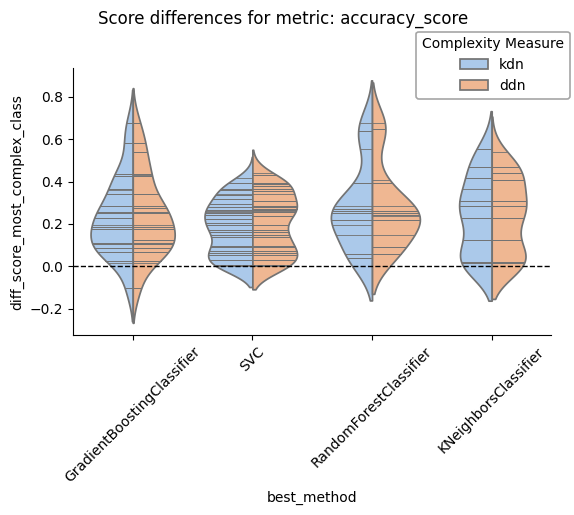

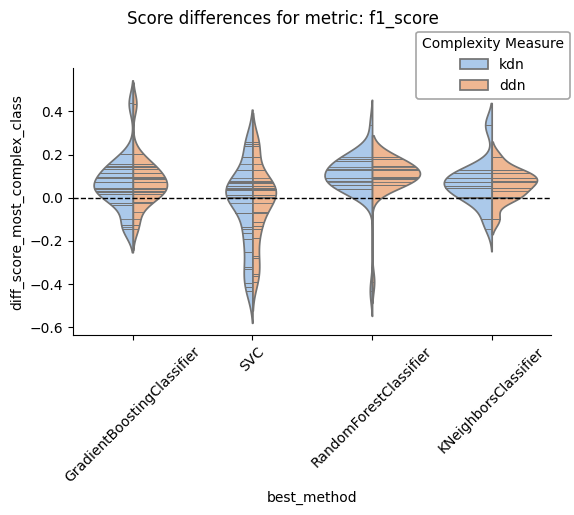

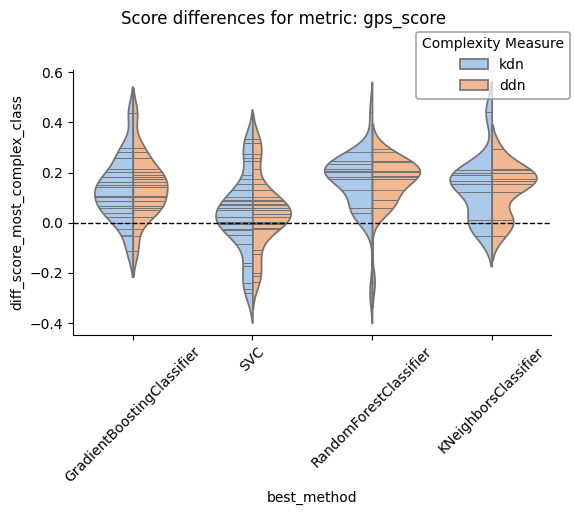

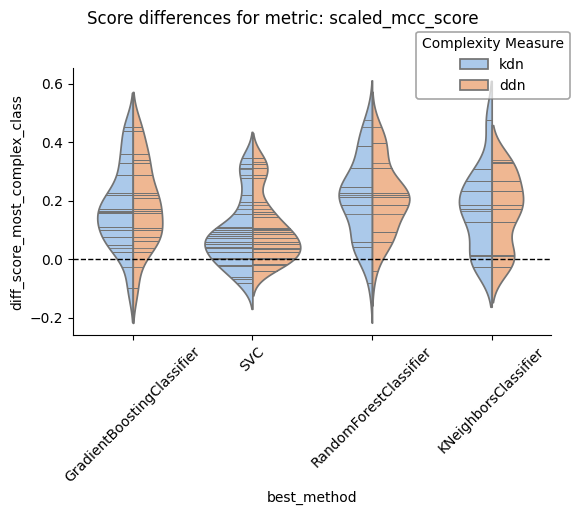

In [6]:
plot_score_differences(df_score_differences, df_performance_results, 1, diff='diff_score_most_complex_class')

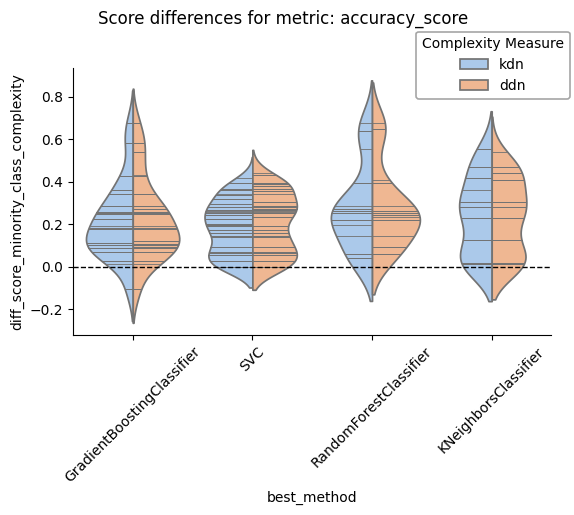

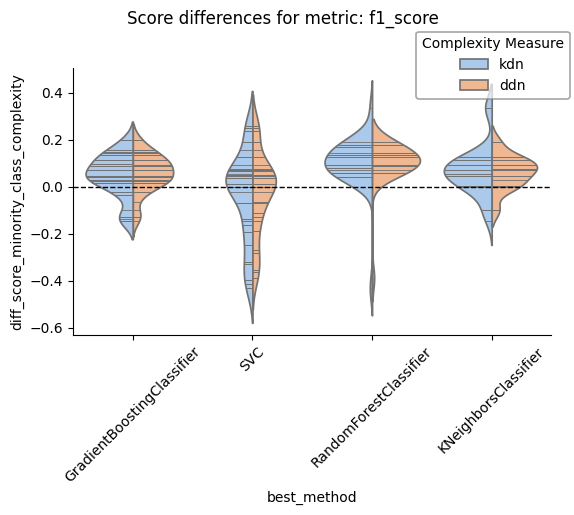

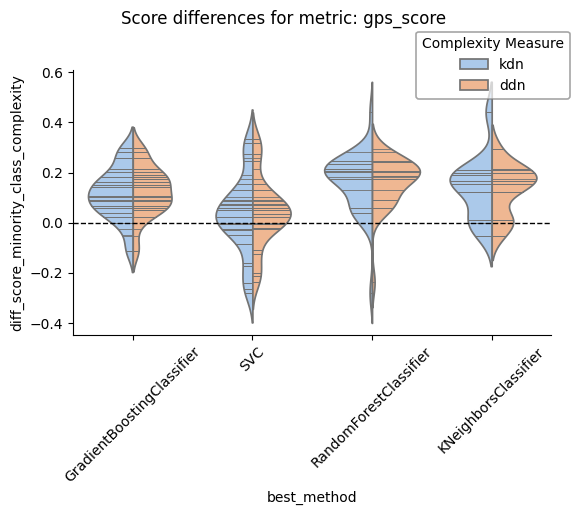

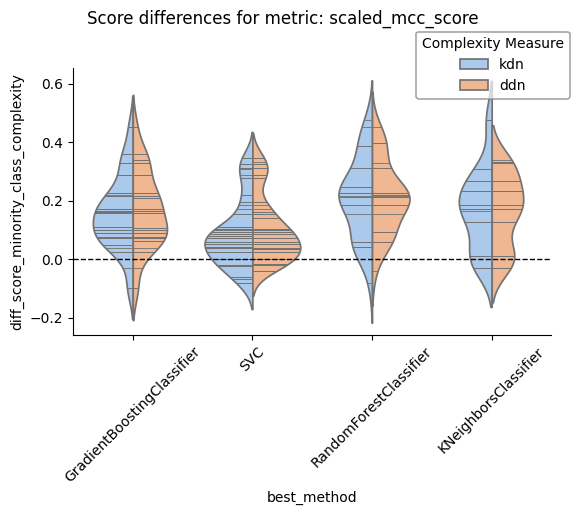

In [7]:
plot_score_differences(df_score_differences, df_performance_results, 1, diff='diff_score_minority_class_complexity')

In [9]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5] 
labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5']
df_description['class_prop_category'] = pd.cut(df_description['class_prop'], bins=bins, labels=labels, include_lowest=True)
df_description.reset_index(inplace=True)
df_description.rename(columns={'index': 'dataset'}, inplace=True)


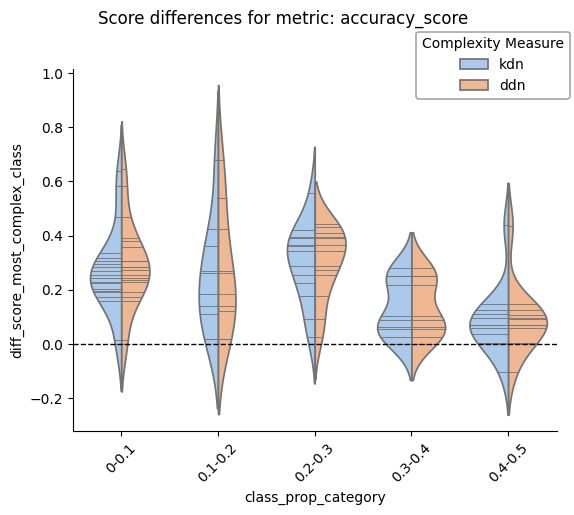

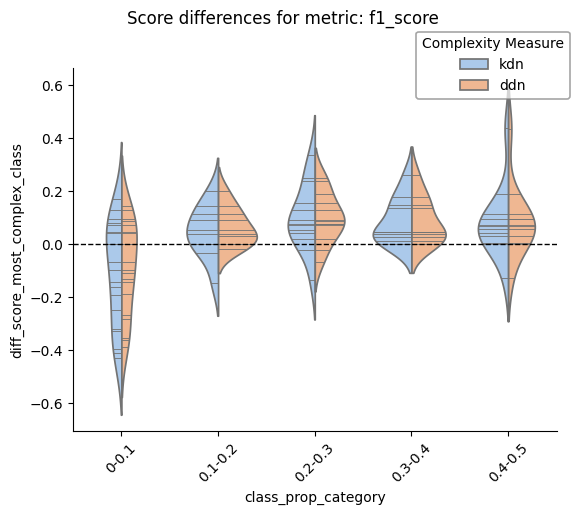

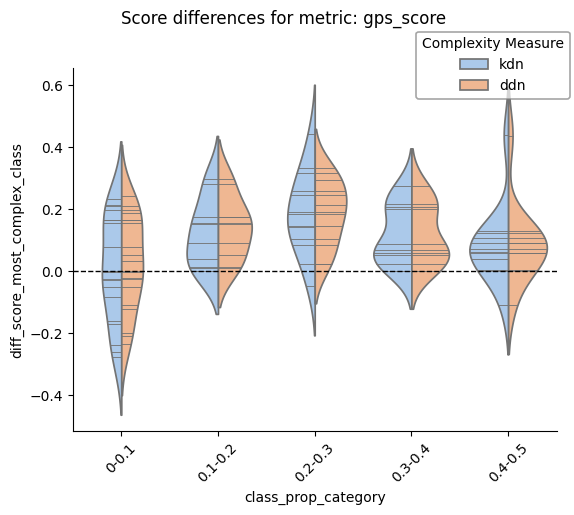

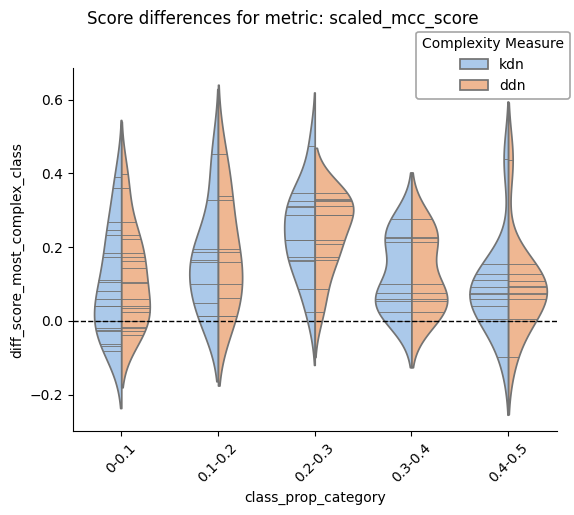

In [11]:
plot_score_differences(df_score_differences, df_description, 1, diff='diff_score_most_complex_class', x_var='class_prop_category')

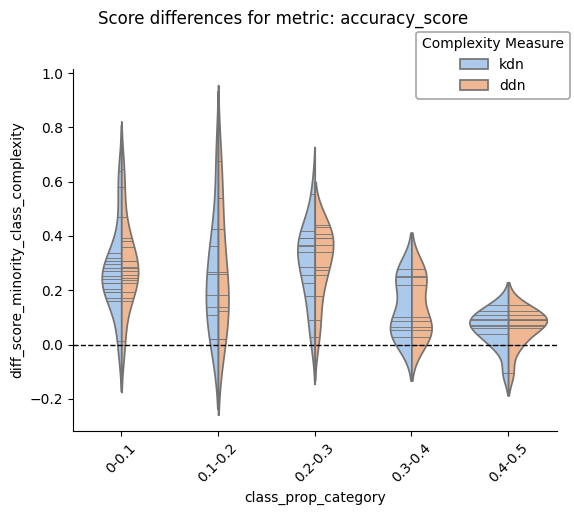

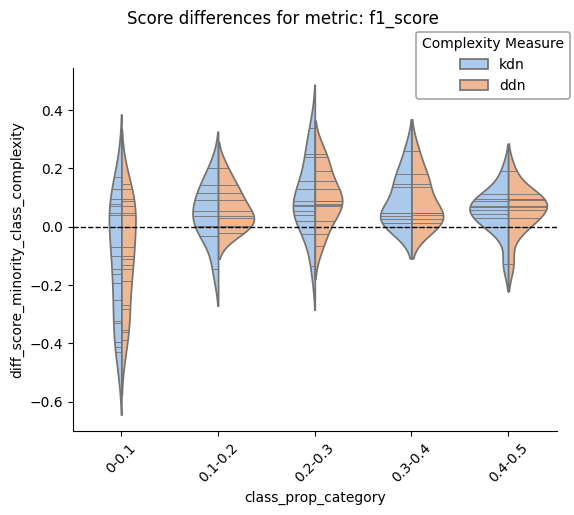

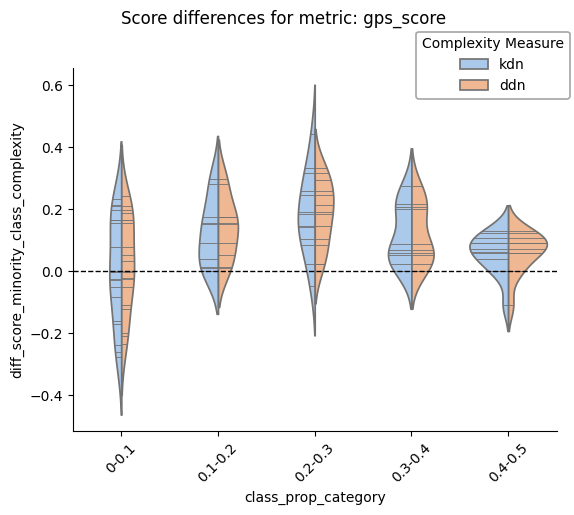

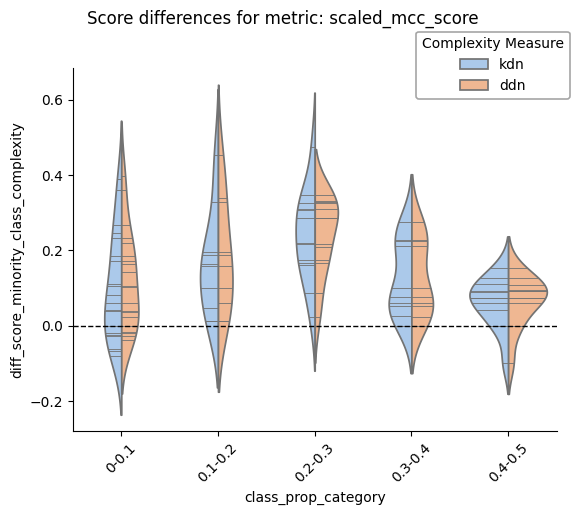

In [10]:
plot_score_differences(df_score_differences, df_description, 1, diff='diff_score_minority_class_complexity', x_var='class_prop_category')